In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 

import matplotlib.pyplot as plt 

from kmodes.kmodes import KModes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix


In [3]:
cardio_df = pd.read_csv("data/cardio.csv",sep=";")
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
#removing Outliers
# Removing the weights and heights, that fall below 2.5% or above 97.5% of a given range.
cardio_df.drop(cardio_df[(cardio_df['height'] > cardio_df['height'].quantile(0.975)) | (cardio_df['height'] < cardio_df['height'].quantile(0.025))].index,inplace=True)
cardio_df.drop(cardio_df[(cardio_df['weight'] > cardio_df['weight'].quantile(0.975)) | (cardio_df['weight'] < cardio_df['weight'].quantile(0.025))].index,inplace=True)

In [5]:
#In some cases diastolic pressure is higher than systolic, which is also  incorrect. How many records are inaccurate in terms of blood pressure?
print("Diastolic pressure is higher than systolic one in {0} cases".format(cardio_df[cardio_df['ap_lo']> cardio_df['ap_hi']].shape[0]))

Diastolic pressure is higher than systolic one in 1082 cases


In [6]:
cardio_df.drop(cardio_df[(cardio_df['ap_hi'] > cardio_df['ap_hi'].quantile(0.975)) | (cardio_df['ap_hi'] < cardio_df['ap_hi'].quantile(0.025))].index,inplace=True)
cardio_df.drop(cardio_df[(cardio_df['ap_lo'] > cardio_df['ap_lo'].quantile(0.975)) | (cardio_df['ap_lo'] < cardio_df['ap_lo'].quantile(0.025))].index,inplace=True)

In [7]:
#Data after removing outliers
cardio_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,49895.698065,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,28840.467755,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,0.000000,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24867.500000,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,49902.500000,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74745.750000,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# transforming the column AGE(measured in days) for Years
cardio_df['years'] = (cardio_df['age'] / 365).round().astype('int')
cardio_df.drop(['age'], axis='columns', inplace=True)
cardio_df.drop(['id'], axis='columns', inplace=True)

In [9]:
# age_bin in quinquenium 5 years spam
cardio_df['age_bin'] = pd.cut(cardio_df['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

In [10]:
# Adding Body Mass Index
cardio_df['bmi'] = cardio_df['weight']/((cardio_df['height']/100)**2)

In [11]:
# transforming the column bmi in Body Mass Index Classes (1 to 6)
rating = []
for row in cardio_df['bmi']:
    if row < 18.5 :    rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   rating.append(2)#NormalWeight
    elif row > 24.9 and row < 29.9:  rating.append(3)#OverWeight
    elif row > 29.9 and row < 34.9:  rating.append(4)#ClassObesity_1
    elif row > 34.9 and row < 39.9:  rating.append(5)#ClassObesity_2
    elif row > 39.9 and row < 49.9:  rating.append(6)#ClassObesity_3
    elif row > 49.9:  rating.append('Error')
        
    else:           rating.append('Not_Rated')

In [12]:
# inserting Column
cardio_df['BMI_Class'] = rating

In [13]:
# general distribuition
cardio_df["BMI_Class"].value_counts(normalize=True)

3    0.391773
2    0.361943
4    0.179209
5    0.055801
6    0.009162
1    0.002112
Name: BMI_Class, dtype: float64

In [14]:
# creating a Column for MAP
cardio_df['MAP'] = ((2* cardio_df['ap_lo']) + cardio_df['ap_hi']) / 3

In [15]:
#Creating Classes for MAP
map_values = []
for row in cardio_df['MAP']:
    if row < 69.9:    map_values.append(1) #Low
    elif row > 70 and row  < 79.9:   map_values.append(2)#Normal
    elif row > 79.9 and row < 89.9:  map_values.append(3)#Normal
    elif row > 89.9 and row < 99.9:  map_values.append(4)#Normal
    elif row > 99.9 and row < 109.9:  map_values.append(5)#High
    elif row > 109.9 and row < 119.9:  map_values.append(6)#Normal
    elif row > 119.9:  map_values.append(7)
        
    else:           map_values.append('Not_Rated')

In [16]:
#inserting MAP_Class Column
cardio_df['MAP_Class'] = map_values

In [17]:
# Reordering Columns
cardio_df= cardio_df[["gender","height","weight","bmi","ap_hi","ap_lo","MAP","years","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio"]]
cardio_df.head()

,gender,height,weight,bmi,ap_hi,ap_lo,MAP,years,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,168,62.0,21.967120,110,80,90.000000,50,45-50,2,4,1,1,0,1,0
1,1,156,85.0,34.927679,140,90,106.666667,55,50-55,5,5,3,1,0,1,1
2,1,165,64.0,23.507805,130,70,90.000000,52,50-55,2,4,3,1,0,0,1
3,2,169,82.0,28.710479,150,100,116.666667,48,45-50,3,6,1,1,0,1,1
4,1,156,56.0,23.011177,100,60,73.333333,48,45-50,2,2,1,1,0,0,0


In [18]:
# only Categorical Data Columns DataFrame
df_cat = cardio_df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio",]]
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,45-50,2,4,1,1,0,1,0
1,1,50-55,5,5,3,1,0,1,1
2,1,50-55,2,4,3,1,0,0,1
3,2,45-50,3,6,1,1,0,1,1
4,1,45-50,2,2,1,1,0,0,0


In [19]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
3,1,3,2,4,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0


In [20]:
df_male = df_cat.query("gender == 1")
df_female = df_cat.query("gender == 0")

In [21]:
# female data
# Building the model with using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([0, 1, 1, ..., 1, 0, 0], dtype=uint16)

In [22]:
df_female.insert(0,"Cluster", clusters_huang_1, True)

# female DataFrame with Clusters
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,1,0,4,4,3,2,0,0,1,1
2,0,0,4,1,2,2,0,0,0,1
4,0,0,3,1,0,0,0,0,0,0
5,0,0,5,2,2,1,1,0,0,0
6,0,0,6,4,2,2,0,0,1,0


In [23]:
df_male.insert(0, "Cluster", clusters_huang_2, True)

# male DataFrame with Clusters
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,0,1,3,1,2,0,0,0,1,0
3,1,1,3,2,4,0,0,0,1,1
7,1,1,6,3,3,2,2,0,1,1
11,0,1,4,1,2,0,0,0,1,0
12,0,1,2,1,2,0,0,0,0,0


In [24]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

C:\Users\Hans\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,1,3,1,2,0,0,0,1,0
3,3,1,3,2,4,0,0,0,1,1
7,3,1,6,3,3,2,2,0,1,1
11,2,1,4,1,2,0,0,0,1,0
12,2,1,2,1,2,0,0,0,0,0


In [65]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

In [26]:
# preprocessing
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [27]:
target_name = 'cardio'
data_target = df_clusters[target_name]
data = df_clusters.drop([target_name], axis=1)

In [28]:
#separate into 30/70%
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=0)

In [29]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=0)

In [30]:
# Gaussian Naive Bayes
#Training
gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

70.89

In [31]:
#Test
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

70.79

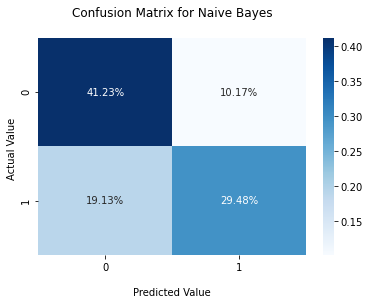

In [32]:
y_pred_gauss = gaussian.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_gauss)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Naive Bayes\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [33]:
print(classification_report(Zval, y_pred_gauss))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74      6491
           1       0.74      0.61      0.67      6139

    accuracy                           0.71     12630
   macro avg       0.71      0.70      0.70     12630
weighted avg       0.71      0.71      0.70     12630



In [34]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree Classifier
# Training

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

86.03

In [35]:
# Decision Tree Classifier
# Testing

acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
acc_test_decision_tree

84.17

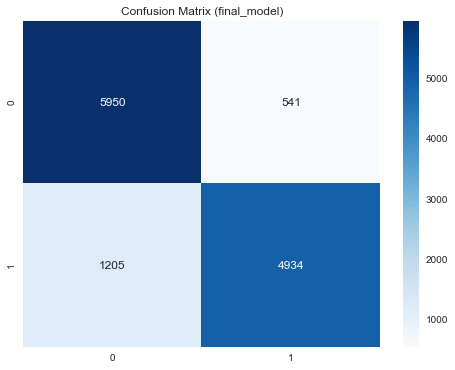

In [64]:
y_pred_dt = decision_tree.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_dt)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (decision_tree)')

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
print(classification_report(Zval, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      6491
           1       0.90      0.80      0.85      6139

    accuracy                           0.86     12630
   macro avg       0.87      0.86      0.86     12630
weighted avg       0.87      0.86      0.86     12630



In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest
# Training
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

86.03 {'n_estimators': 300}


In [39]:
# Random Forest
# Test
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
acc_test_random_forest

84.3

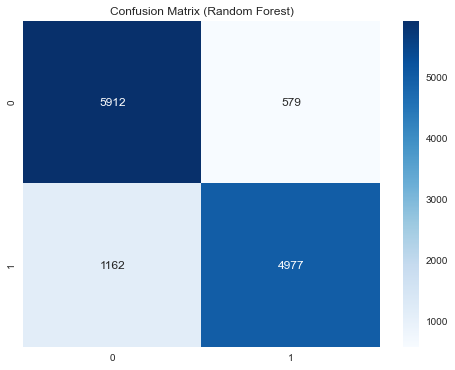

In [62]:
y_pred_df = random_forest.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_df)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Random Forest)')

## Display the visualization of the Confusion Matrix.
plt.show()

In [41]:
print(classification_report(Zval, y_pred_df))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      6491
           1       0.90      0.81      0.85      6139

    accuracy                           0.86     12630
   macro avg       0.87      0.86      0.86     12630
weighted avg       0.86      0.86      0.86     12630



In [42]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
# Training
logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

81.82

In [43]:
# Logistic Regression
# Testing
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

81.65

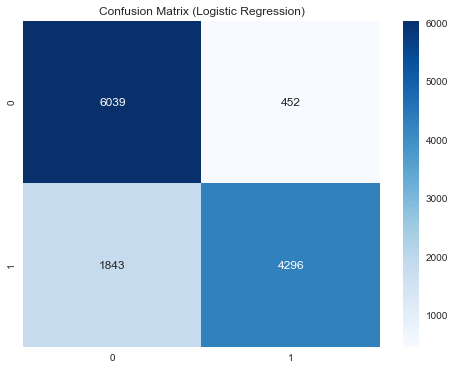

In [63]:
y_pred_lr = logreg.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_lr)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Logistic Regression)')

## Display the visualization of the Confusion Matrix.
plt.show()

In [45]:
print(classification_report(Zval, y_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      6491
           1       0.90      0.70      0.79      6139

    accuracy                           0.82     12630
   macro avg       0.84      0.82      0.81     12630
weighted avg       0.83      0.82      0.82     12630



In [46]:
from pycaret.classification import *

clf1 = setup(data = df_clusters, 
             target = 'cardio',
             preprocess = False,
             silent = True)

,Description,Value
0,session_id,7707
1,Target,cardio
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(60142, 10)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,8
8,Transformed Train Set,"(42099, 9)"
9,Transformed Test Set,"(18043, 9)"


In [47]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [48]:
top5 = compare_models(sort='AUC',
                    n_select = 5,
                 )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8454,0.9316,0.7928,0.8785,0.8334,0.6899,0.6931,0.2010
gbc,Gradient Boosting Classifier,0.8448,0.9304,0.7781,0.8901,0.8303,0.6886,0.6939,0.2500
et,Extra Trees Classifier,0.8446,0.9264,0.7872,0.8817,0.8317,0.6882,0.6921,0.1970
dt,Decision Tree Classifier,0.8444,0.9256,0.7864,0.8820,0.8314,0.6879,0.6918,0.0610
ada,Ada Boost Classifier,0.8331,0.9169,0.7558,0.8856,0.8155,0.6649,0.6719,0.8310
knn,K Neighbors Classifier,0.8219,0.9013,0.8029,0.8273,0.8148,0.6434,0.6439,0.4260
lr,Logistic Regression,0.8177,0.8740,0.6998,0.9050,0.7892,0.6332,0.6495,0.3690
lda,Linear Discriminant Analysis,0.8173,0.8739,0.6791,0.9270,0.7839,0.6321,0.6552,0.0640
qda,Quadratic Discriminant Analysis,0.8165,0.8726,0.7583,0.8495,0.8013,0.6319,0.6354,0.0620
nb,Naive Bayes,0.7090,0.7776,0.6089,0.7478,0.6712,0.4151,0.4222,0.0600


In [49]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8485,0.9370,0.7881,0.8885,0.8353,0.6959,0.7002
1,0.8501,0.9339,0.8086,0.8746,0.8403,0.6995,0.7014
2,0.8373,0.9281,0.8043,0.8537,0.8283,0.6739,0.6750
3,0.8504,0.9375,0.7955,0.8861,0.8384,0.6998,0.7033
4,0.8423,0.9324,0.7872,0.8769,0.8297,0.6836,0.6871
5,0.8425,0.9309,0.7858,0.8786,0.8296,0.6841,0.6877
6,0.8461,0.9365,0.7882,0.8837,0.8332,0.6912,0.6951
7,0.8456,0.9354,0.7736,0.8957,0.8302,0.6900,0.6963
8,0.8475,0.9382,0.7955,0.8804,0.8358,0.6941,0.6972


In [50]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8475,0.9366,0.7857,0.8887,0.8340,0.6940,0.6985
1,0.8523,0.9325,0.7979,0.8878,0.8404,0.7036,0.7071
2,0.8375,0.9272,0.7897,0.8655,0.8259,0.6742,0.6767
3,0.8489,0.9363,0.7960,0.8828,0.8372,0.6970,0.7002
4,0.8411,0.9326,0.7863,0.8753,0.8284,0.6812,0.6846
5,0.8401,0.9306,0.7804,0.8784,0.8265,0.6793,0.6833
6,0.8482,0.9357,0.7902,0.8864,0.8355,0.6955,0.6994
7,0.8458,0.9341,0.7790,0.8914,0.8314,0.6906,0.6959
8,0.8511,0.9354,0.7965,0.8867,0.8392,0.7012,0.7047


In [51]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8456,0.0000,0.7852,0.8852,0.8322,0.6902,0.6944
1,0.8492,0.0000,0.7988,0.8808,0.8378,0.6975,0.7004
2,0.8378,0.0000,0.7882,0.8672,0.8258,0.6746,0.6773
3,0.8499,0.0000,0.7980,0.8831,0.8384,0.6989,0.7020
4,0.8413,0.0000,0.7853,0.8766,0.8285,0.6817,0.6853
5,0.8397,0.0000,0.7790,0.8786,0.8258,0.6783,0.6825
6,0.8468,0.0000,0.7882,0.8852,0.8339,0.6926,0.6966
7,0.8451,0.0000,0.7829,0.8864,0.8314,0.6892,0.6938
8,0.8473,0.0000,0.7936,0.8816,0.8353,0.6936,0.6970


In [52]:
#prediction
pred = blend_soft.predict(test)
#Accuracy
confusion_hard = confusion_matrix(target_test, pred)
accuracy = accuracy_score(target_test , pred)
precision = precision_score(target_test , pred)
recall = recall_score(target_test , pred)
f1 = f1_score(target_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8560, precision: 0.8911, recall: 0.8034,F1: 0.8450


In [53]:
#prediction
pred = stack_model.predict(test)
#Accuracy
confusion_hard = confusion_matrix(target_test, pred)
accuracy = accuracy_score(target_test , pred)
precision = precision_score(target_test , pred)
recall = recall_score(target_test , pred)
f1 = f1_score(target_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8521, precision: 0.8832, recall: 0.8035,F1: 0.8415


In [54]:
#prediction
pred = blend_hard.predict(test)
#Accuracy
confusion_hard = confusion_matrix( target_test, pred)
accuracy = accuracy_score(target_test , pred)
precision = precision_score(target_test , pred)
recall = recall_score(target_test , pred)
f1 = f1_score(target_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8555, precision: 0.8930, recall: 0.8000,F1: 0.8440


In [55]:
final_model = finalize_model(stack_model)

In [58]:
#prediction
pred = final_model.predict(test)
#Accuracy
confusion_hard = confusion_matrix(target_test, pred)
accuracy = accuracy_score(target_test, pred)
precision = precision_score(target_test, pred)
recall = recall_score(target_test, pred)
f1 = f1_score(target_test, pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8503, precision: 0.8847, recall: 0.7975,F1: 0.8389


In [1]:
#prediction
pred = final_model.predict(Xval)
#Accuracy
confusion_hard = confusion_matrix( Zval, pred)
accuracy = accuracy_score(Zval , pred)
precision = precision_score(Zval , pred)
recall = recall_score(Zval , pred)
f1 = f1_score(Zval,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

NameError: name 'final_model' is not defined

Text(0.5, 1.0, 'Confusion Matrix (final_model)')

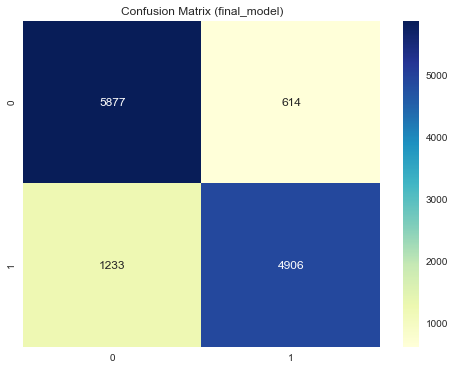

In [57]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')